In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_palette("Pastel2")


In [47]:
data_to_use = ""       # set to "" to use the unfiltered version
vid_annot = pd.read_csv(f"data/urbansas{data_to_use}/video_annotations.csv").drop(columns="Unnamed: 0")
aud_annot = pd.read_csv(f"data/urbansas{data_to_use}/audio_annotations.csv").drop(columns="Unnamed: 0")

# filter vid annot
vid_annot = vid_annot[vid_annot["label"] != -1]
vid_annot = vid_annot[vid_annot["frame_id"] != -1]


In [48]:
vid_annot.head()

,frame_id,track_id,x,y,w,h,class_id,visibility,label,filename,city,location_id,time,night
0,1,1,526.40,453.05,172.41,98.25,1,1.0,car,rivera0923_00_6,montevideo,rivera0923,0.0,0
1,1,2,947.42,400.28,38.87,65.35,4,1.0,motorbike,rivera0923_00_6,montevideo,rivera0923,0.0,0
2,2,3,1928.46,400.66,212.64,143.32,1,1.0,car,rivera0923_00_6,montevideo,rivera0923,0.5,0
3,2,1,375.66,444.97,172.41,98.25,1,0.0,car,rivera0923_00_6,montevideo,rivera0923,0.5,0
4,2,2,947.42,400.28,38.87,65.35,4,1.0,motorbike,rivera0923_00_6,montevideo,rivera0923,0.5,0


In [49]:
aud_annot.head()

,filename,class_id,label,non_identifiable_vehicle_sound,start,end
0,street_traffic-barcelona-161-4901,0,car,0,0.294,3.106
1,street_traffic-barcelona-161-4901,2,bus,0,6.648,9.961
2,street_traffic-barcelona-161-4902,0,car,0,7.877,9.836
3,street_traffic-barcelona-161-4902,0,car,0,4.752,7.273
4,street_traffic-barcelona-161-4903,-1,-1,1,-1.000,-1.000


In [50]:
vid_annot.shape[0]

41743

## Basic Statistics

* Label distribution
   
* Day-Night split
   
* Time distribution
   
* City Distribution
   
* Visibility Split


Text(0.5, 1.0, 'Audio Annotations')

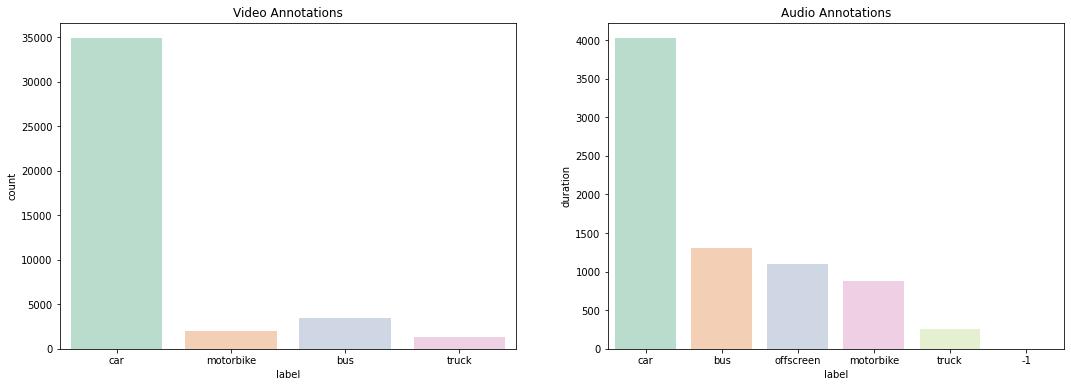

In [51]:
"""
Label Distribution

"""
# get classwise durations for audio annotations
aud_annot["duration"] = aud_annot["end"] - aud_annot["start"]
durations = aud_annot.groupby("label").sum().reset_index()[["label", "duration"]]

fig, ax = plt.subplots(1, 2, figsize = (18, 6))
sns.countplot(x = "label", data = vid_annot, ax = ax[0])
sns.barplot(x = "label", y = "duration",  data = durations, ax = ax[1], 
            order=durations.sort_values('duration', ascending=False).label)
ax[0].set_title("Video Annotations")
ax[1].set_title("Audio Annotations")



## Observations 

Significant imbalance in labels. Cars are overrepresented in both audio and video. However, audio annotations look relatively more balanced. The reason might be multiple cars in one frame. Every car would get its own annotation in the image, but would be not in the audio (get more info on annotations).

<AxesSubplot:xlabel='night', ylabel='count'>

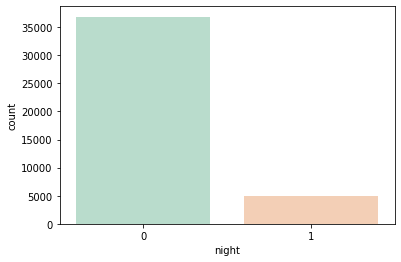

In [52]:
"""
Day-Night split
"""
sns.countplot(x = "night", data=vid_annot)

<AxesSubplot:xlabel='time', ylabel='Count'>

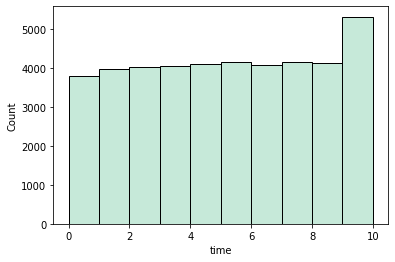

In [53]:
""" 
Time 

"""
sns.histplot(x = "time", data=vid_annot, bins = 10)

<AxesSubplot:xlabel='count', ylabel='city'>

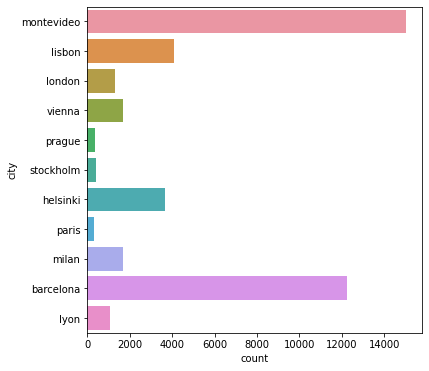

In [54]:
""" 
City Distribution

"""
plt.subplots(figsize = (6, 6))
sns.countplot(y="city", data=vid_annot)

(-1.0, 2.0)

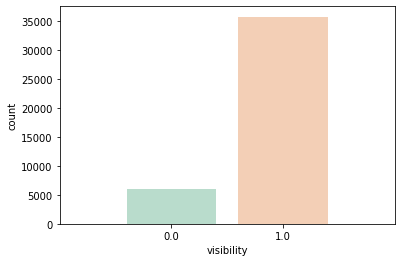

In [56]:
""" 
Visibility

"""

sns.countplot(x="visibility", data=vid_annot)
plt.xlim(-1,2)

In [57]:
""" 
Do all files have both audio and video annotations?
"""
vid_files = set(vid_annot["filename"])
aud_files = set(aud_annot["filename"])

vid_only = [i for i in vid_files if i not in aud_files]
vid_only

"""Yes, all files have both annotations."""

'Yes, all files have both annotations.'

## More Questions

1. How many vehicles per frame? (classwise)
2. Average Speed of vehicles (classwise)
3. How much overlap between audio and video annotations?
   

### 1. How many vehicles per frame? (classwise)

In [58]:
framewise_cts = {"filename":[],"frame_id":[], "car":[], "motorbike":[], "truck":[], "bus":[]}
filenames = sorted(list(set(vid_annot["filename"])))
categories = ["car", "truck", "motorbike", "bus"]
for fname in filenames:
    sub_annot = vid_annot[vid_annot["filename"] == fname]
    for fr in range(max(sub_annot["frame_id"]+1)):
        counts = sub_annot[sub_annot["frame_id"] == fr]["label"].value_counts()
        for category in categories:
            if category in counts:
                framewise_cts[category].append(counts[category])
            else:
                framewise_cts[category].append(0)
        framewise_cts["filename"].append(fname)
        framewise_cts["frame_id"].append(fr)


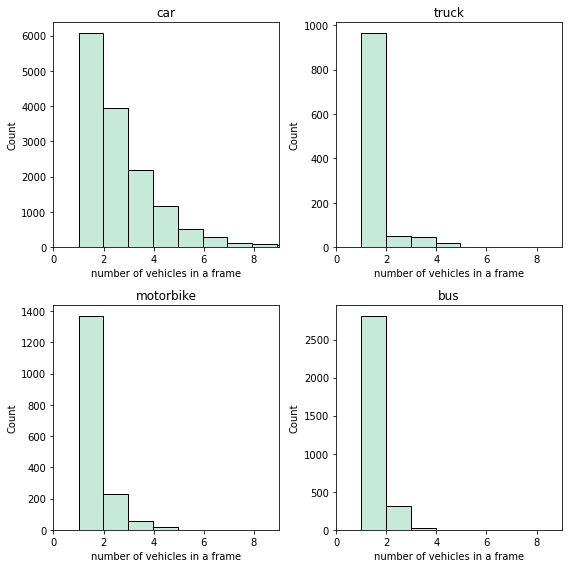

In [59]:
plt.figure(figsize = (8, 8))
for i in range(4):
    category = categories[i]
    cts = np.array(framewise_cts[category])
    cts = cts[(cts>0) & (cts<10)]                         # don't plot 0s and values greater than 10
    plt.subplot(2, 2, i+1)
    sns.histplot(cts, binwidth=0.99)
    plt.title(category)
    plt.xlabel("number of vehicles in a frame")
    plt.xlim(0, 9)
plt.tight_layout()


### There are frames with upto 4 trucks. Let's take a look at those

In [60]:
# get the filename with maximum number for each category
print("Files with maximum numbers of instances for the following categories:")
for category in categories:
    max_idx = np.argmax(framewise_cts[category])
    fname = framewise_cts["filename"][max_idx]
    print(f"{category} - {fname}")
    


Files with maximum numbers of instances for the following categories:
car - street_traffic-barcelona-163-4994
truck - street_traffic-barcelona-163-4975
motorbike - street_traffic-barcelona-161-4915
bus - street_traffic-helsinki-165-5050


In [61]:
print("Files with minimum numbers of instances for the following categories:")
for category in categories:
    max_idx = np.argmin(framewise_cts[category])
    fname = framewise_cts["filename"][max_idx]
    print(f"{category} - {fname}")

Files with minimum numbers of instances for the following categories:
car - acevedo0103_00_0
truck - acevedo0103_00_0
motorbike - acevedo0103_00_0
bus - acevedo0103_00_0


In [62]:
vid_annot_sub = vid_annot[vid_annot.filename == "rivera0923_00_6"].set_index("frame_id")
vid_annot_sub

,track_id,x,y,w,h,class_id,visibility,label,filename,city,location_id,time,night
frame_id,,,,,,,,,,,,,
1,1,526.40,453.05,172.41,98.25,1,1.0,car,rivera0923_00_6,montevideo,rivera0923,0.0,0
1,2,947.42,400.28,38.87,65.35,4,1.0,motorbike,rivera0923_00_6,montevideo,rivera0923,0.0,0
2,3,1928.46,400.66,212.64,143.32,1,1.0,car,rivera0923_00_6,montevideo,rivera0923,0.5,0
2,1,375.66,444.97,172.41,98.25,1,0.0,car,rivera0923_00_6,montevideo,rivera0923,0.5,0
2,2,947.42,400.28,38.87,65.35,4,1.0,motorbike,rivera0923_00_6,montevideo,rivera0923,0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,2,947.42,400.28,38.87,65.35,4,1.0,motorbike,rivera0923_00_6,montevideo,rivera0923,9.0,0
20,5,3.20,365.20,121.60,99.10,3,0.0,bus,rivera0923_00_6,montevideo,rivera0923,9.5,0
20,9,212.47,464.03,193.33,118.37,1,0.0,car,rivera0923_00_6,montevideo,rivera0923,9.5,0
